In [ ]:
# TensorFlow ve Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Diğer gerekli kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Veri setinizin yolu
data_dir = '/content/drive/MyDrive/Colab Notebooks/money detection project/full_dataset'

# Sınıf isimlerini otomatik olarak almak için
classes = sorted(os.listdir(data_dir))
print("Sınıflar:", classes)


Sınıflar: ['1.emisyon', '2.emisyon', '3.emisyon', '4.emisyon', '5.emisyon']


In [ ]:
# Veri ön işleme (sadece yeniden ölçeklendirme)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # %80 eğitim, %20 doğrulama
)

# Eğitim veri seti
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # Xception için giriş boyutu
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Doğrulama veri seti
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 7446 images belonging to 5 classes.
Found 1858 images belonging to 5 classes.


In [ ]:
# Xception modelini yükleme (imagenet ağırlıkları ile, son katman hariç)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Tüm katmanları dondurma (eğitilmeyecek)
base_model.trainable = False

# Modelin üzerine ek katmanlar ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Son model
model = Model(inputs=base_model.input, outputs=predictions)

# Model özetini görüntüleme
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Hiperparametreler
learning_rate = 0.001
batch_size = 32
epochs = 20

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitme
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


232/232 ━━━━━━━━━━━━━━━━━━━━ 2308s 10s/step - accuracy: 0.7510 - loss: 0.6500 - val_accuracy: 0.6250 - val_loss: 1.6236
Epoch 2/20
  1/232 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - accuracy: 0.9688 - loss: 0.1267

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9688 - loss: 0.1267 - val_accuracy: 1.0000 - val_loss: 0.0561
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 163s 690ms/step - accuracy: 0.9708 - loss: 0.0952 - val_accuracy: 0.6514 - val_loss: 1.4830
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step - accuracy: 1.0000 - loss: 0.0497 - val_accuracy: 1.0000 - val_loss: 8.5067e-04
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 144s 606ms/step - accuracy: 0.9846 - loss: 0.0524 - val_accuracy: 0.6072 - val_loss: 1.8111
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.9688 - loss: 0.1067 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 201s 600ms/step - accuracy: 0.9895 - loss: 0.0350 - val_accuracy: 0.6934 - val_loss: 1.7476
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 2.0764e-04
Epoch 9/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 144s 608ms/step - accuracy: 0.9899 - loss: 0.031

# **Hiperparametre	Değer**
Öğrenme Oranı	0.001 -
Batch Boyutu	32 -
Epoch Sayısı	20 -
Optimizatör	Adam -
Kayıp Fonksiyonu -	Categorical Crossentropy

59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 557ms/step
Sınıflandırma Raporu:
               precision    recall  f1-score   support

   1.emisyon       0.69      0.79      0.74       275
   2.emisyon       0.60      0.95      0.74       603
   3.emisyon       0.56      0.30      0.39       409
   4.emisyon       0.85      0.83      0.84       150
   5.emisyon       0.90      0.50      0.64       421

    accuracy                           0.67      1858
   macro avg       0.72      0.67      0.67      1858
weighted avg       0.69      0.67      0.65      1858



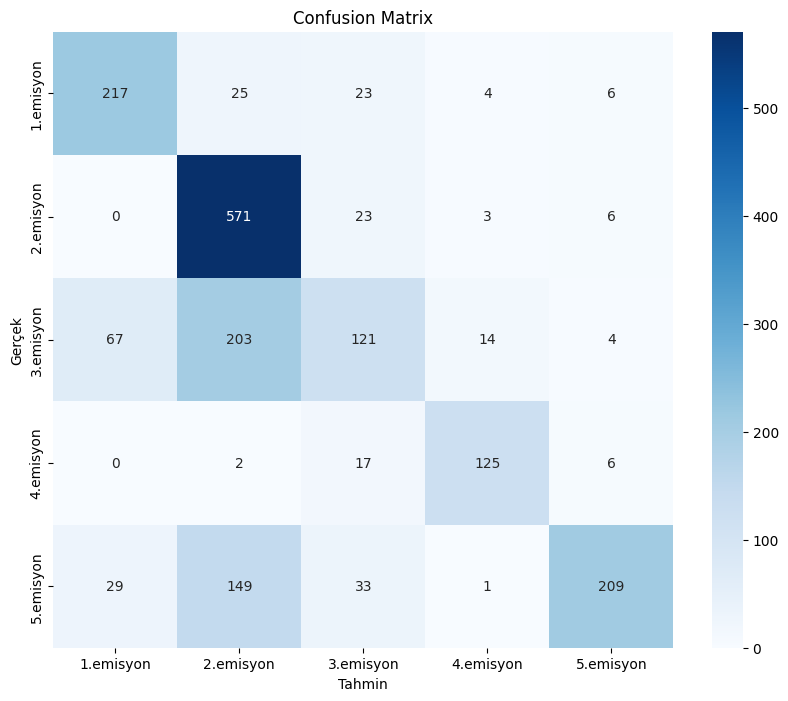

Genel Doğruluk (Accuracy): 0.6690
Genel Precision: 0.6941
Genel Recall: 0.6690
Genel F1-Score: 0.6462


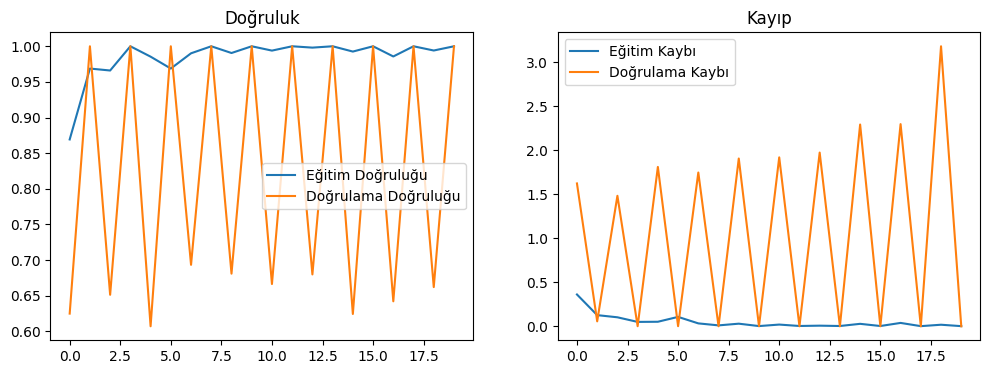

In [ ]:
# Gerekli Kütüphaneleri İçe Aktarma
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Doğrulama verileri üzerinde tahmin yapma
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Her emisyon için sınıflandırma raporu
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Sınıflandırma Raporu:\n", report)

# Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.title('Confusion Matrix')
plt.show()

# Genel başarı metriklerini hesaplama
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=0)

# Genel metrikleri yazdırma
print(f"Genel Doğruluk (Accuracy): {accuracy:.4f}")
print(f"Genel Precision: {precision:.4f}")
print(f"Genel Recall: {recall:.4f}")
print(f"Genel F1-Score: {f1:.4f}")

# Eğitim ve Doğrulama Doğruluğunu Görselleştirme
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title('Doğruluk')

# Eğitim ve Doğrulama Kayıpını Görselleştirme
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.title('Kayıp')
plt.show()
